In [1]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpBinary
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_players = pd.read_parquet('df_players.parquet')
df_positions = pd.read_parquet('df_positions.parquet')
df_teams = pd.read_parquet('df_teams.parquet')

In [2]:
# Budget
my_budget = 40.0  

# Liste des noms des joueurs à ajouter
selected_names = ["Sánchez", "Dúbravka", "Guéhi", "Senesi", "Van de Ven", "Konsa", "Rodon", "M.Salah", "Reijnders",  
                   "Semenyo", "B.Fernandes", "Caicedo", "", "João Pedro", "Haaland", "Kroupi.Jr"]  # Remplace par les noms souhaités

# Filtrer df_players pour obtenir les joueurs sélectionnés
df_my_team = df_players[df_players["web_name"].isin(selected_names)]

# Afficher l'équipe sélectionnée
df_my_team.sort_values(by = ['position'])

,first_name,web_name,team_short,team_name,position,price,total_points,points_per_cost,points_per_minutes,fdr_next_6,ict_index,selected_by_percent,selected_rank,form,minutes,transfers_in,transfers_in_event,transfers_out,transfers_out_event,assists,goals_scored,goal_involvements,expected_goals,expected_assists,expected_goal_involvements,GI_on_xGI,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,defensive_contribution_per_90
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72,Marcos,Senesi,BOU,Bournemouth,DEF,48.0,37.0,0.770833,0.082222,3.166667,20.2,16.5,22,8.7,450.0,1891122,684816,166601,22297,1.0,0.0,1.0,0.14,0.15,0.29,3.448276,0.03,0.00,0.03,0.06,0.72,1.00,13.20
260,Marc,Guéhi,CRY,Crystal Palace,DEF,47.0,36.0,0.765957,0.080000,3.333333,18.0,25.1,12,9.3,450.0,1831703,289957,377021,91562,1.0,1.0,2.0,0.39,0.04,0.43,4.651163,0.08,0.00,0.01,0.09,0.94,0.40,7.20
575,Micky,Van de Ven,TOT,Spurs,DEF,47.0,28.0,0.595745,0.063781,2.666667,16.3,34.0,6,5.3,439.0,1472832,259539,566459,91833,0.0,1.0,1.0,0.68,0.03,0.71,1.408451,0.14,0.00,0.01,0.15,1.23,0.62,5.54
348,Joe,Rodon,LEE,Leeds,DEF,40.0,22.0,0.550000,0.048889,2.666667,10.5,4.3,84,4.3,450.0,385168,113504,134862,35304,0.0,0.0,0.0,0.00,0.01,0.01,0.000000,0.00,0.00,0.00,0.00,1.30,1.40,9.40
38,Ezri,Konsa,AVL,Aston Villa,DEF,45.0,12.0,0.266667,0.035821,3.333333,8.5,11.8,37,3.0,335.0,169683,20980,1052347,117254,0.0,0.0,0.0,0.00,0.07,0.07,0.000000,0.00,0.00,0.02,0.02,1.86,1.07,4.84
249,João Pedro,João Pedro,CHE,Chelsea,FWD,78.0,35.0,0.448718,0.083333,2.833333,36.3,67.8,1,6.0,420.0,2569589,277452,965482,207045,3.0,2.0,5.0,1.50,0.20,1.70,2.941176,0.32,0.00,0.04,0.36,1.05,0.86,4.71
430,Erling,Haaland,MCI,Man City,FWD,143.0,46.0,0.321678,0.111380,3.000000,52.2,46.4,4,10.3,413.0,2820444,1092736,609517,72612,0.0,6.0,6.0,6.18,0.32,6.50,0.923077,1.35,0.00,0.07,1.42,1.30,0.87,4.36
100,Eli Junior,Kroupi.Jr,BOU,Bournemouth,FWD,45.0,3.0,0.066667,0.250000,3.166667,0.2,1.5,153,0.3,12.0,169786,23119,124168,20876,0.0,0.0,0.0,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,1.80,7.50,7.50
470,Martin,Dúbravka,BUR,Burnley,GKP,40.0,17.0,0.425000,0.037778,3.166667,14.3,34.4,5,3.0,450.0,683404,111566,361589,66982,0.0,0.0,0.0,0.00,0.00,0.00,NaN,0.00,3.80,0.00,0.00,2.05,1.60,0.00


In [3]:
df_my_team.sum(numeric_only=True)['price'] # Coût total de l'équipe sélectionnée

np.float64(1008.0)

In [4]:
# Je dois composer une équipe de 15 joueurs, je veux savoir si je peux l'améliorer en respectant les contraintes suivantes :
# Mon budget est défini par la valeur my_budget (paramètre à modifier)
# Je dois respecter la composition d'équipe suivante : 2 Gardiens (GKP), 5 Défenseurs (DEF), 5 Milieux (MID), 3 Attaquants (FWD)
# Je ne peux pas avoir plus de 3 joueurs appartenant à la même équipe
# Je veux maximiser le nombre de points que mon équipe peut potentiellement rapporter
# Les critères me permettant de déterminer si un joueur va performer : les points_per_cost, l'ict_index, les points_per_minutes, le fdr_next_6 (plus la valeur est basse, plus le calendrier est facile et donc le joueur a de chances de performer)
# La base de données df_players contient les informations nécessaires pour chaque joueur
# A l'aide de Pulp, je vais résoudre ce problème d'optimisation linéaire en utilisant la programmation linéaire 

In [5]:
corr = df_players['ict_index'].corr(df_players['total_points'])
print(f"Corrélation entre ict_index et total_points : {corr:.3f}")


Corrélation entre ict_index et total_points : 0.880


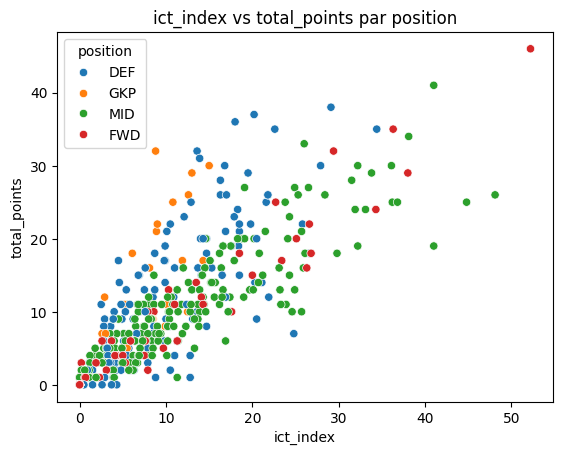

In [6]:
sns.scatterplot(data=df_players, x='ict_index', y='total_points', hue='position')
plt.title('ict_index vs total_points par position')
plt.show()


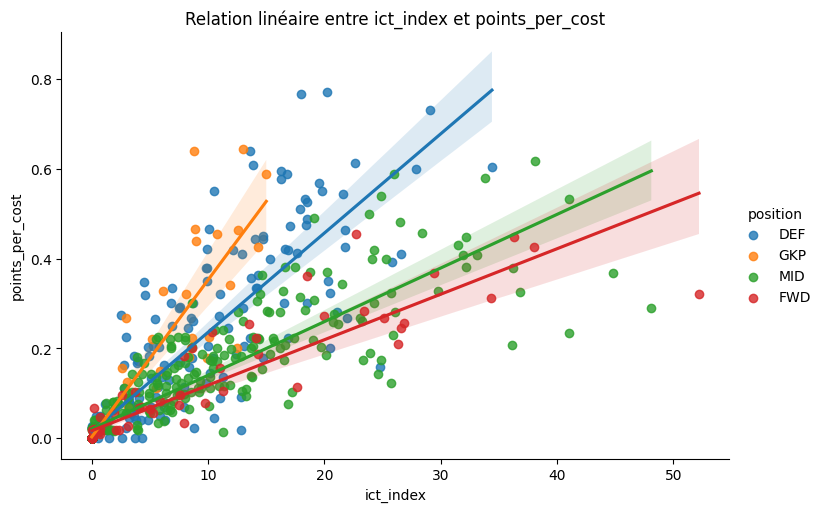

In [ ]:
sns.lmplot(data=df_players, x='ict_index', y='points_per_cost', hue='position', aspect=1.5)
plt.title('Relation linéaire entre ict_index et points_per_cost')
plt.show()

In [8]:
import plotly.express as px

fig = px.scatter(
    df_players[df_players['position'] == 'MID'],  # Filtrer pour éviter les joueurs sans minutes
    x='ict_index',
    y='points_per_cost',
    text='web_name',  # Affiche le nom au survol
    color='position', # Optionnel, couleur par poste
    title='ict_index vs points_per_cost (Hover pour nom du joueur)'
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.show()

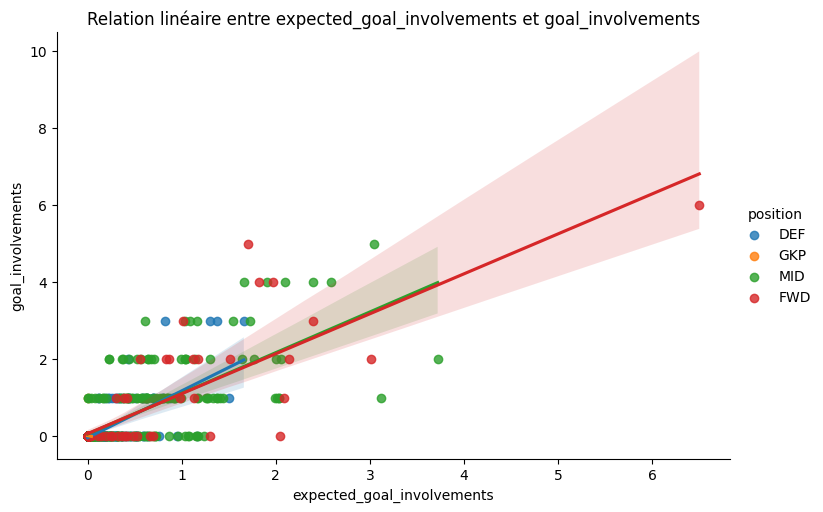

In [9]:
sns.lmplot(data=df_players, x='expected_goal_involvements', y='goal_involvements', hue='position', aspect=1.5)
plt.title('Relation linéaire entre expected_goal_involvements et goal_involvements')
plt.show()


In [10]:
import plotly.express as px

fig = px.scatter(
    df_players,
    x='expected_goal_involvements',
    y='goal_involvements',
    text='web_name',  # Affiche le nom au survol
    color='position', # Optionnel, couleur par poste
    title='Relation linéaire entre expected_goal_involvements et goal_involvements (Hover pour nom du joueur)'
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.show()